In [54]:
# Manejo de datos...
import pandas as pd
import numpy as np
import random

# Gráficos...
import matplotlib.pyplot as plt
import seaborn as sns

# Procesamiento...
from sklearn.preprocessing import MinMaxScaler

# Modelo...
from keras.models import Sequential
from keras.layers import LSTM, Dense

import tensorflow as tf

# Manejo de archivos...
import os
from pathlib import Path

# Series de tiempo...
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Por cuestiones técnicas el dataset no será utilizado con sus time stamps, sino que se abortará el estudio de series de tiempo...

Pensando en la reproducibilidad...

In [55]:
# Fijar la Semilla...
seed = 123

# Fijar la semilla en el generador de números aleatorios de Python
random.seed(seed)

# Fijar la semilla en NumPy
np.random.seed(seed)

# Fijar la semilla en TensorFlow
tf.random.set_seed(seed)

Cargando los datos...

In [56]:
processed_folder = Path.cwd().parent / 'data' / 'processed'
df = pd.read_parquet(processed_folder / "df_model_tidy_lasso.parquet")
df

,potencia,rendimiento,ruido,f80,per_solidos,spi,imp_criticos,presion
date,,,,,,,,
2022-11-15 00:07:50,39281.348296,65.653747,22.932414,36.574719,71.583049,54.50695,7.101110,87.199926
2022-11-15 00:08:00,39850.320731,65.691489,22.932414,36.555098,71.579590,54.50695,7.191338,87.402467
2022-11-15 00:08:10,39761.319456,65.783858,21.329909,36.535478,71.585002,54.50695,7.281566,87.492231
2022-11-15 00:08:20,39761.319456,65.906084,21.329909,36.515857,71.598714,54.50695,7.371795,87.492231
2022-11-15 00:08:30,39665.960948,65.986245,22.538648,36.583533,71.615886,54.50695,7.462023,87.564041
...,...,...,...,...,...,...,...,...
2022-12-14 23:59:20,41194.875702,71.307249,8.845677,45.849870,77.265464,38.54322,0.900937,89.175128
2022-12-14 23:59:30,41194.875702,71.403265,8.845677,45.931528,77.298097,38.54322,0.899591,89.175128
2022-12-14 23:59:40,40686.296989,71.458539,8.845677,46.134072,77.327109,38.54322,0.898244,89.181349


Explorando...

In [57]:
df.describe()

,potencia,rendimiento,ruido,f80,per_solidos,spi,imp_criticos,presion
count,259154.000000,259154.000000,259154.000000,259154.000000,259154.000000,259154.000000,259154.000000,259154.000000
mean,37054.395950,59.072620,10.193782,38.866987,75.002457,50.403541,2.059740,88.474581
std,4333.582367,8.617083,5.254049,13.643086,3.408024,14.982860,2.648737,3.542660
min,21125.088265,24.500046,0.000000,10.703177,50.338806,0.000000,0.000000,68.339688
25%,34529.315953,55.046023,6.129741,28.849000,73.428497,43.581005,0.189884,86.213327
50%,38216.511617,61.221810,10.353884,37.113858,75.787171,50.392814,1.159502,88.436259
75%,40320.756040,64.765008,13.517695,48.025720,77.610189,58.236956,3.171461,90.830952
max,45390.650079,75.371860,49.926609,91.966382,81.595704,100.000000,62.633323,100.000000


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 259154 entries, 2022-11-15 00:07:50 to 2022-12-15 00:00:00
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   potencia      259154 non-null  float64
 1   rendimiento   259154 non-null  float64
 2   ruido         259154 non-null  float64
 3   f80           259154 non-null  float64
 4   per_solidos   259154 non-null  float64
 5   spi           259154 non-null  float64
 6   imp_criticos  259154 non-null  float64
 7   presion       259154 non-null  float64
dtypes: float64(8)
memory usage: 17.8 MB


Series de tiempo...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


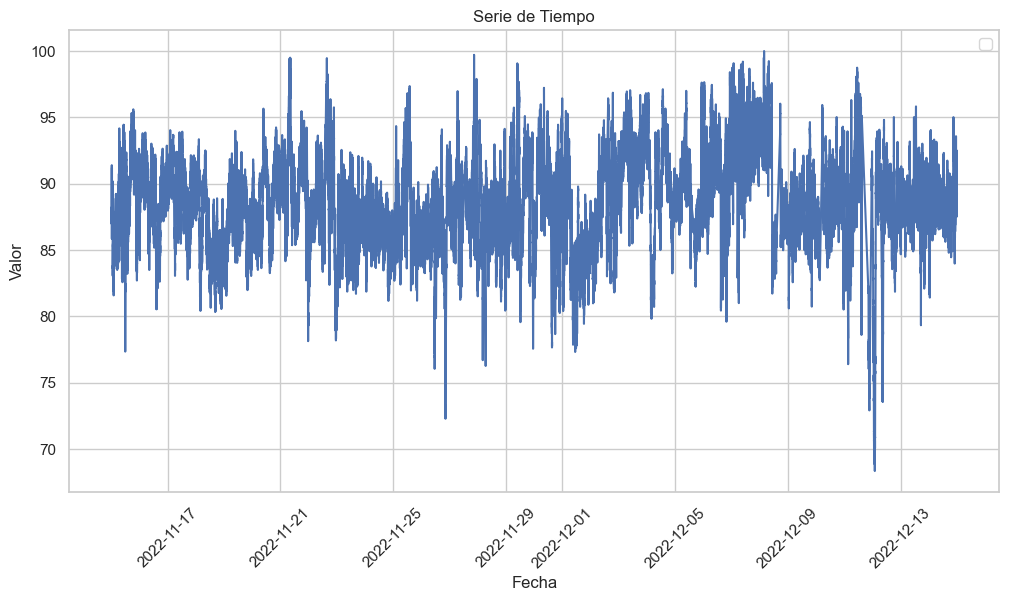

In [59]:
# Configurar el estilo de los gráficos
sns.set(style='whitegrid')

# Visualización de la serie de tiempo
plt.figure(figsize=(12, 6))
plt.plot(df["presion"])
plt.title('Serie de Tiempo')
plt.xlabel('Fecha')
plt.xticks(rotation = 45)
plt.ylabel('Valor')
plt.legend()
plt.show()

Descomposición de la Serie de Tiempo

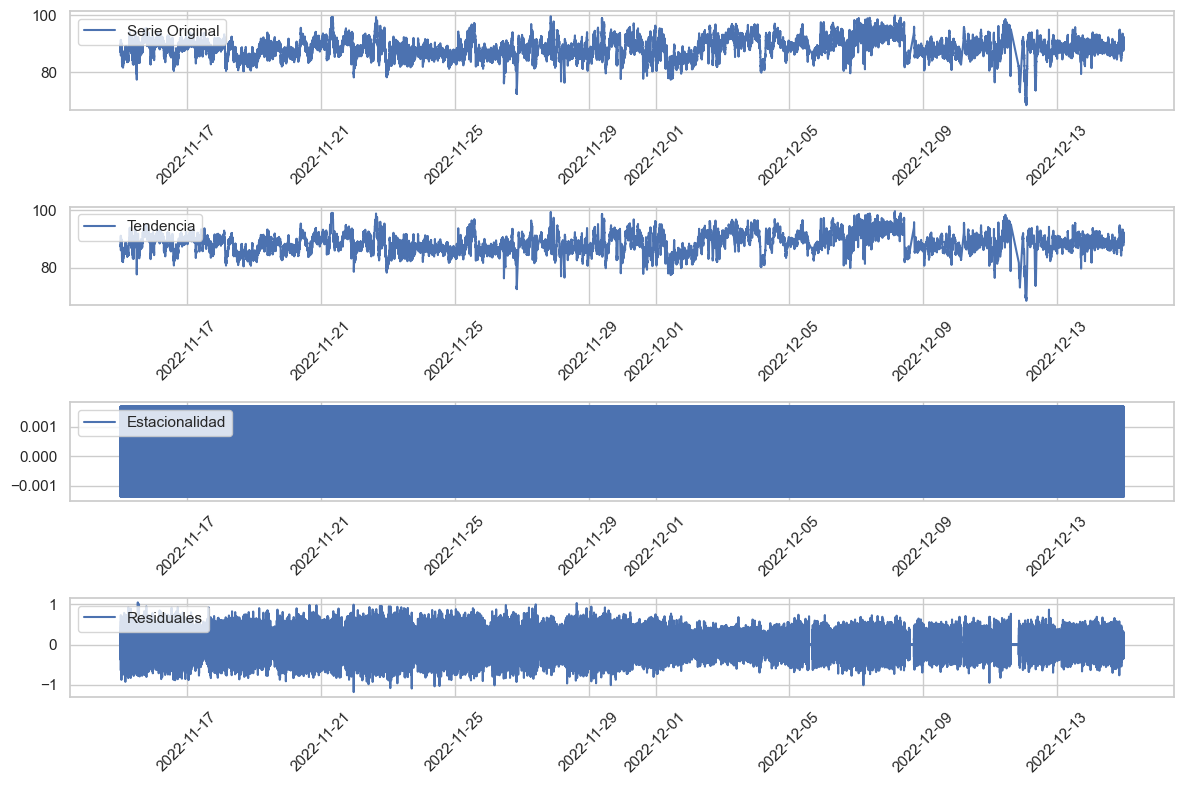

In [60]:
# Realizar la descomposición
decomposition = seasonal_decompose(df["presion"], model='additive', period = 10)

# Extraer los componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Visualizar los componentes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df["presion"], label='Serie Original')
plt.legend(loc='upper left')
plt.xticks(rotation = 45)

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='upper left')
plt.xticks(rotation = 45)

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.xticks(rotation = 45)

plt.subplot(414)
plt.plot(residual, label='Residuales')
plt.legend(loc='upper left')
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

Análisis de Autocorrelación

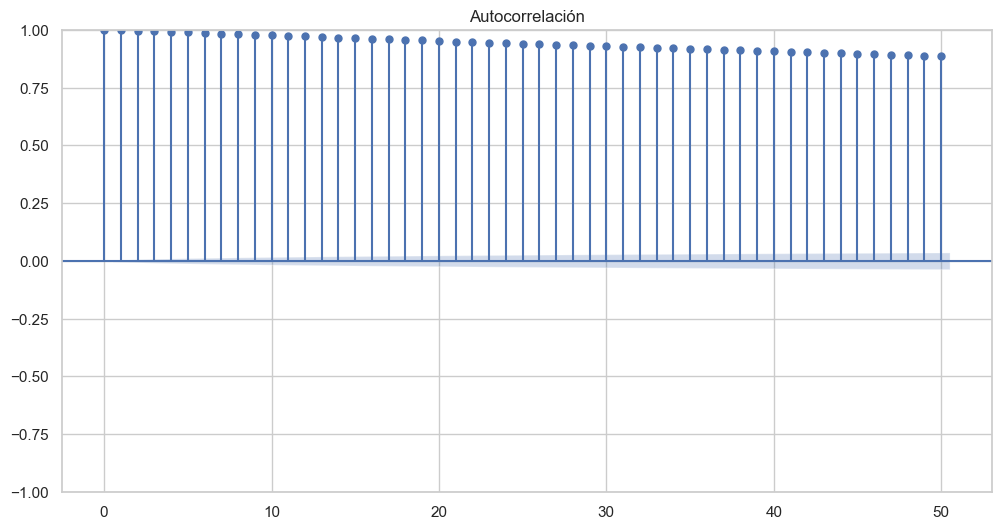

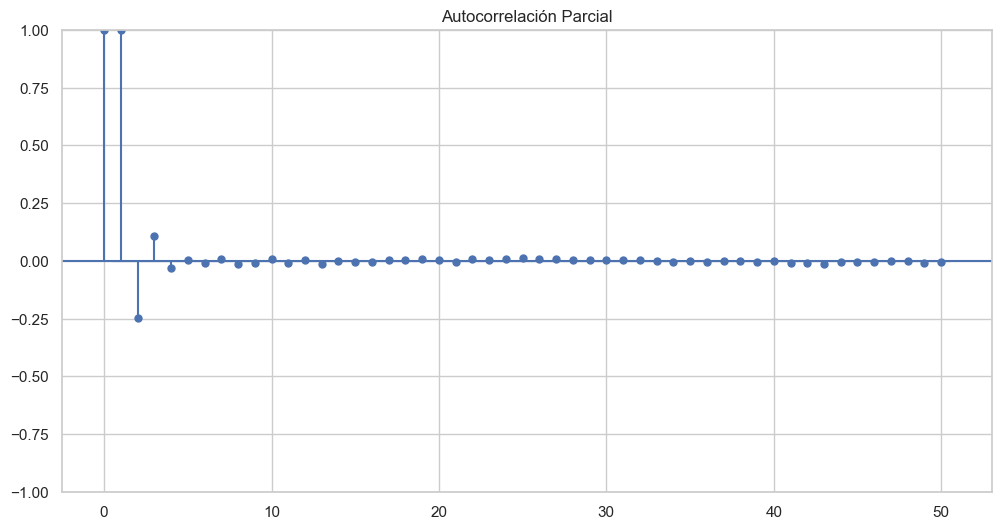

In [61]:
# Autocorrelación
plt.figure(figsize=(12, 6))
plot_acf(df["presion"], lags=50, ax=plt.gca())
plt.title('Autocorrelación')
plt.show()

# Autocorrelación Parcial
plt.figure(figsize=(12, 6))
plot_pacf(df["presion"], lags=50, ax=plt.gca())
plt.title('Autocorrelación Parcial')
plt.show()

Dividir los datos para el entrenamiento / validación / test...

In [62]:
# Definir el tamaño del conjunto de datos...
n = len(df)

# Dividir en 80% entrenamiento y 20% prueba...
train_size = int(n * 0.8)
test_size = n - train_size

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

print(f"Tamaño del conjunto de entrenamiento: {len(train_data)}")
print(f"Tamaño del conjunto de prueba: {len(test_data)}")

Tamaño del conjunto de entrenamiento: 207323
Tamaño del conjunto de prueba: 51831


In [63]:
# Definir el tamaño del conjunto de entrenamiento y validación
n_train = len(train_data)
train_train_size = int(n_train * 0.8)
train_val_size = n_train - train_train_size

train_train_data = train_data.iloc[:train_train_size]
train_val_data = train_data.iloc[train_train_size:]

print(f"Tamaño del conjunto de entrenamiento (final): {len(train_train_data)}")
print(f"Tamaño del conjunto de validación: {len(train_val_data)}")

Tamaño del conjunto de entrenamiento (final): 165858
Tamaño del conjunto de validación: 41465


Guardando los conjuntos de datos en formato parquet...

In [64]:
train_train_data.to_parquet(processed_folder / "df_model_tidy_lasso_train.parquet")
train_val_data.to_parquet(processed_folder / "df_model_tidy_lasso_val.parquet")
test_data.to_parquet(processed_folder / "df_model_tidy_lasso_test.parquet")

In [ ]:
# train_train_data.index = pd.to_datetime(train_train_data.index)  # Convertir el índice a tipo datetime si no lo está
# train_train_data = train_train_data.asfreq('10S')  # Establecer la frecuencia de los datos a 10 segundos

Revisar: ARIMAX, SARIMAX, ARIMA.

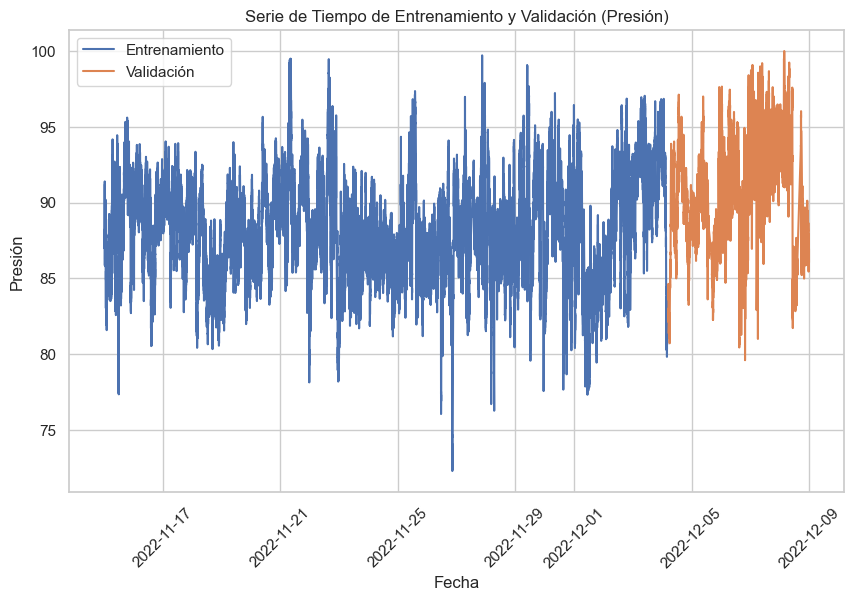

In [68]:
# Visualizar la serie de tiempo de entrenamiento y validación
plt.figure(figsize=(10, 6))
plt.plot(train_train_data["presion"], label='Entrenamiento')
plt.plot(train_val_data["presion"], label='Validación')
plt.xlabel('Fecha')
plt.ylabel('Presión')
plt.title('Serie de Tiempo de Entrenamiento y Validación (Presión)')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

Estacionariedad de la Serie de Tiempo de Entrenamiento:
ADF Statistic: -15.001215231391898
p-value: 1.0891185789230328e-27
Critical Values:
   1%: -3.430389442454871
   5%: -2.8615574330233473
   10%: -2.5667792789750203


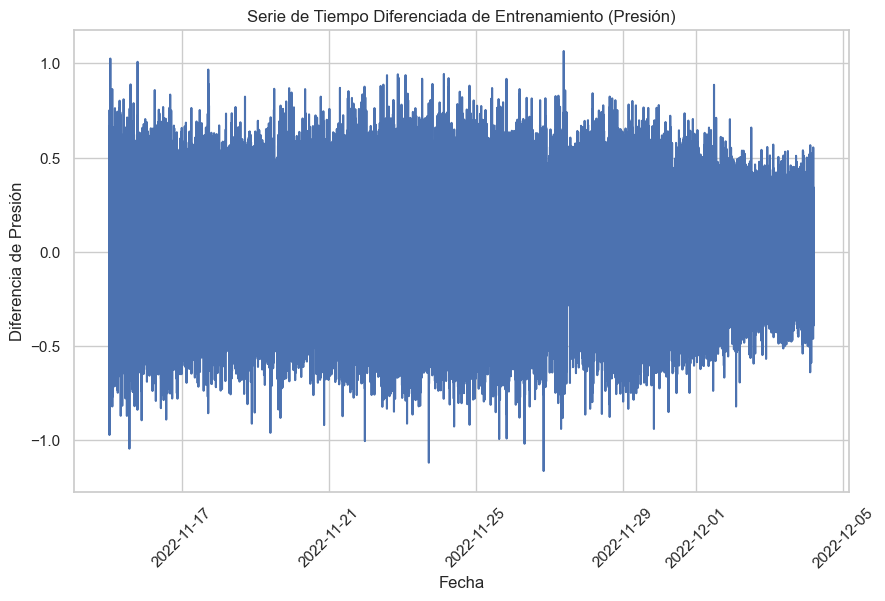


Estacionariedad de la Serie de Tiempo Diferenciada de Entrenamiento:
ADF Statistic: -49.86288571116467
p-value: 0.0
Critical Values:
   1%: -3.430389442454871
   5%: -2.8615574330233473
   10%: -2.5667792789750203


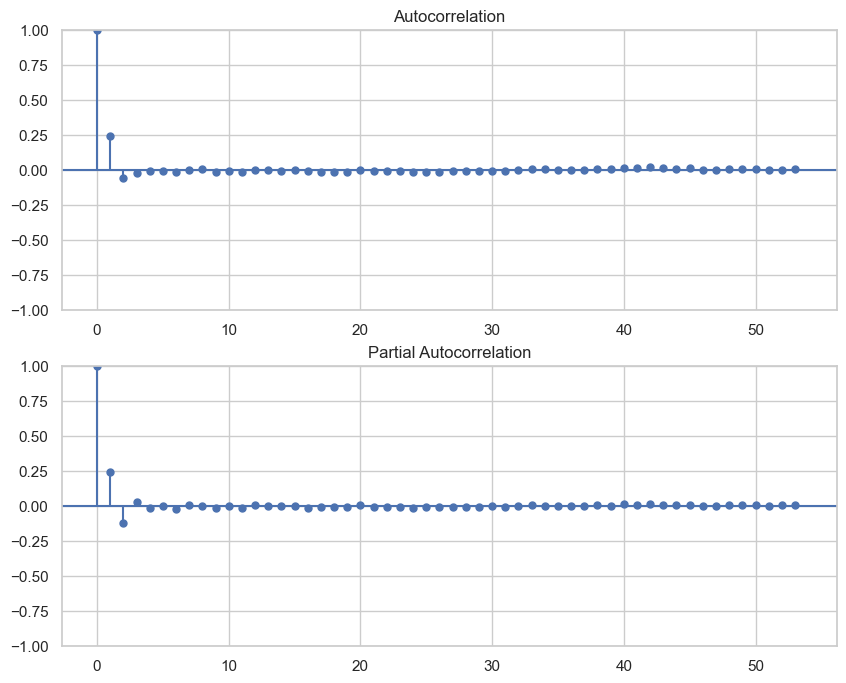

In [71]:
# Función para verificar la estacionariedad de la serie de tiempo
def check_stationarity(ts):
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Verificar la estacionariedad de la serie de tiempo de entrenamiento
print("Estacionariedad de la Serie de Tiempo de Entrenamiento:")
check_stationarity(train_train_data["presion"])

# Diferenciación para hacer la serie estacionaria
diff_train_train_data = train_train_data["presion"].diff().dropna()

# Visualizar la serie de tiempo diferenciada de entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(diff_train_train_data)
plt.xlabel('Fecha')
plt.xticks(rotation = 45)
plt.ylabel('Diferencia de Presión')
plt.title('Serie de Tiempo Diferenciada de Entrenamiento (Presión)')
plt.show()

# Verificar la estacionariedad de la serie de tiempo diferenciada de entrenamiento
print("\nEstacionariedad de la Serie de Tiempo Diferenciada de Entrenamiento:")
check_stationarity(diff_train_train_data)

# Autocorrelación y Autocorrelación Parcial
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(diff_train_train_data, ax=axes[0])
plot_pacf(diff_train_train_data, ax=axes[1])
plt.show()

C:\Users\mcd\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  self._init_dates(dates, freq)
C:\Users\mcd\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  self._init_dates(dates, freq)
C:\Users\mcd\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  self._init_dates(dates, freq)
C:\Users\mcd\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mcd\AppData\Roaming\Python\Python311\site-packages\

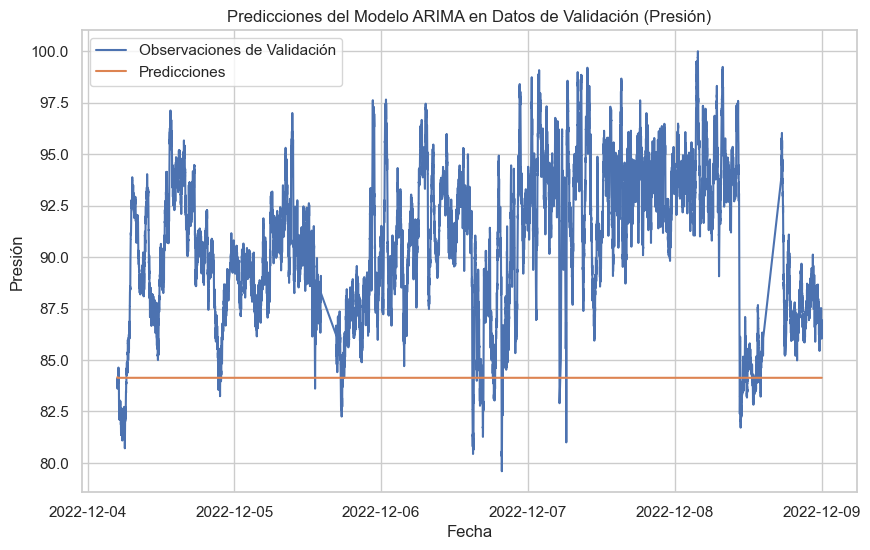

In [74]:
# Ajustar el modelo ARIMA... Por defecto... order = (1, 1, 1)...
order = (3, 1, 1)  # Parámetros del modelo ARIMA (p, d, q)
model = ARIMA(train_train_data["presion"], order=order)
result = model.fit()

#    p: Representa la memoria del modelo AR.
#    d: Representa la diferenciación necesaria para hacer estacionaria la serie de tiempo.
#    q: Representa la memoria del modelo MA.

# Hacer predicciones
forecast = result.predict(start=len(train_train_data["presion"]), end=len(train_train_data["presion"])+len(train_val_data["presion"])-1)

# Visualizar las predicciones
plt.figure(figsize=(10, 6))
plt.plot(train_val_data["presion"], label='Observaciones de Validación')
plt.plot(forecast, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Presión')
plt.title('Predicciones del Modelo ARIMA en Datos de Validación (Presión)')
plt.legend()
plt.show()

Ajustar parámetros... probar otros modelos... hacer una búsqueda con un gridsearch???